In [18]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, precision_recall_curve
from tensorflow.keras.callbacks import EarlyStopping

In [19]:
def read_fasta(path):
    with open(path) as f:
        lines = f.readlines()
        seq = "".join([l.strip() for l in lines if not l.startswith(">")])
    return seq

def one_hot_encode(seq):
    mapping = {"A":0, "C":1, "G":2, "T":3}
    arr = np.zeros((len(seq), 4), dtype=np.float32)
    for i, s in enumerate(seq):
        if s in mapping:
            arr[i, mapping[s]] = 1
    return arr

def sliding_windows(sequence, window_size, stride=200):
    for i in range(0, len(sequence) - window_size + 1, stride):
        yield sequence[i:i+window_size]

In [20]:
positive_dir = '/content/sample_data/positive'
negative_dir = '/content/sample_data/negative'

pos_files = [os.path.join(positive_dir, fname) for fname in os.listdir(positive_dir) if fname.endswith('.fasta')]
pos_sequences = [read_fasta(f) for f in pos_files]

neg_files = [os.path.join(negative_dir, fname) for fname in os.listdir(negative_dir) if fname.endswith('.fasta')]
neg_sequences = [read_fasta(f) for f in neg_files]

# One-hot encode all sequences (full length, varying lengths)
X_pos = [one_hot_encode(seq) for seq in pos_sequences]
X_neg = [one_hot_encode(seq) for seq in neg_sequences]

# Creating labels
y_pos = [1]*len(X_pos)
y_neg = [0]*len(X_neg)

# Combining and shuffling data
X = X_pos + X_neg
y = y_pos + y_neg
X, y = shuffle(X, y, random_state=42)

print(f"Loaded {len(X)} total sequences: {sum(y)} positive and {len(y)-sum(y)} negative.")

Loaded 96 total sequences: 48 positive and 48 negative.


In [21]:
def pad_or_truncate(seq_onehot, desired_len=5000):
    curr_len = seq_onehot.shape[0]
    if curr_len > desired_len:
        return seq_onehot[:desired_len, :]
    elif curr_len < desired_len:
        pad = np.zeros((desired_len - curr_len, 4), dtype=np.float32)
        return np.vstack([seq_onehot, pad])
    else:
        return seq_onehot

desired_len = 5000
X_processed = np.array([pad_or_truncate(x, desired_len) for x in X])
y_processed = np.array(y)

print(f"Processed data shape: {X_processed.shape}")

Processed data shape: (96, 5000, 4)


In [22]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_processed, y_processed, test_size=0.2, stratify=y_processed, random_state=42)

print(f"Training samples: {X_train.shape}, Validation samples: {X_val.shape}")

Training samples: (76, 5000, 4), Validation samples: (20, 5000, 4)


In [23]:
model = models.Sequential([
    layers.Conv1D(64, 15, activation='relu', input_shape=(desired_len, 4)),
    layers.MaxPooling1D(4),
    layers.Conv1D(128, 15, activation='relu'),
    layers.MaxPooling1D(4),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 4986, 64)       │         3,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 1246, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 1232, 128)      │       123,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 308, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 39424)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │     2,523,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,650,177 (10.11 MB)

 Trainable params: 2,650,177 (10.11 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
earlystop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), callbacks=[earlystop])

Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 876ms/step - accuracy: 0.5317 - loss: 1.4241 - val_accuracy: 0.5000 - val_loss: 0.7334
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.6351 - loss: 0.6492 - val_accuracy: 1.0000 - val_loss: 0.2288
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 679ms/step - accuracy: 0.9817 - loss: 0.2058 - val_accuracy: 1.0000 - val_loss: 0.0232
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 669ms/step - accuracy: 0.9817 - loss: 0.0457 - val_accuracy: 1.0000 - val_loss: 0.0015
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 756ms/step - accuracy: 0.9895 - loss: 0.0249 - val_accuracy: 1.0000 - val_loss: 4.8482e-04
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.9895 - loss: 0.0086 - val_accuracy: 1.0000 - val_loss: 0.0022
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 753ms/step - accuracy: 1.0000 - loss: 0.0033 - val_accuracy: 1.0000 - val_loss: 3.2324e-04


In [25]:
testing_dir = "/content/sample_data/testing"
window_size = 4242
stride = 500
desired_len = 5000

test_files = [os.path.join(testing_dir, f) for f in os.listdir(testing_dir) if f.endswith('.fasta')]
y_true = []
y_pred_proba = []

for fpath in test_files:
    print(f"Processing {fpath}...")
    seq = read_fasta(fpath)
    windows = list(sliding_windows(seq, window_size, stride))
    if len(windows) == 0:
        print("No windows generated, skipping.")
        continue
    # One-hot encode and pad/truncate each window to the desired_len
    X_test_windows = np.array([pad_or_truncate(one_hot_encode(w), desired_len) for w in windows])
    preds = model.predict(X_test_windows)
    max_pred = np.max(preds)
    y_pred_proba.append(max_pred)

    y_true.append(1 if 'pos' in fpath.lower() else 0)
    print(f"Max predicted probability: {max_pred:.4f}")

Processing /content/sample_data/testing/dna_sequence_66.fasta...
125/125 ━━━━━━━━━━━━━━━━━━━━ 33s 265ms/step
Max predicted probability: 0.4582
Processing /content/sample_data/testing/dna_sequence_64.fasta...
125/125 ━━━━━━━━━━━━━━━━━━━━ 33s 260ms/step
Max predicted probability: 0.4516
Processing /content/sample_data/testing/dna_sequence_65.fasta...
125/125 ━━━━━━━━━━━━━━━━━━━━ 32s 256ms/step
Max predicted probability: 0.4588
Processing /content/sample_data/testing/d503_4.fasta...
63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 256ms/step
Max predicted probability: 0.5078
Processing /content/sample_data/testing/dna_sequence_67.fasta...
125/125 ━━━━━━━━━━━━━━━━━━━━ 33s 264ms/step
Max predicted probability: 0.4518
Processing /content/sample_data/testing/d502_2.fasta...
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 277ms/step
Max predicted probability: 0.4805
Processing /content/sample_data/testing/d503_3.fasta...
63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 253ms/step
Max predicted probability: 0.5178
Processing /content/sample_data/

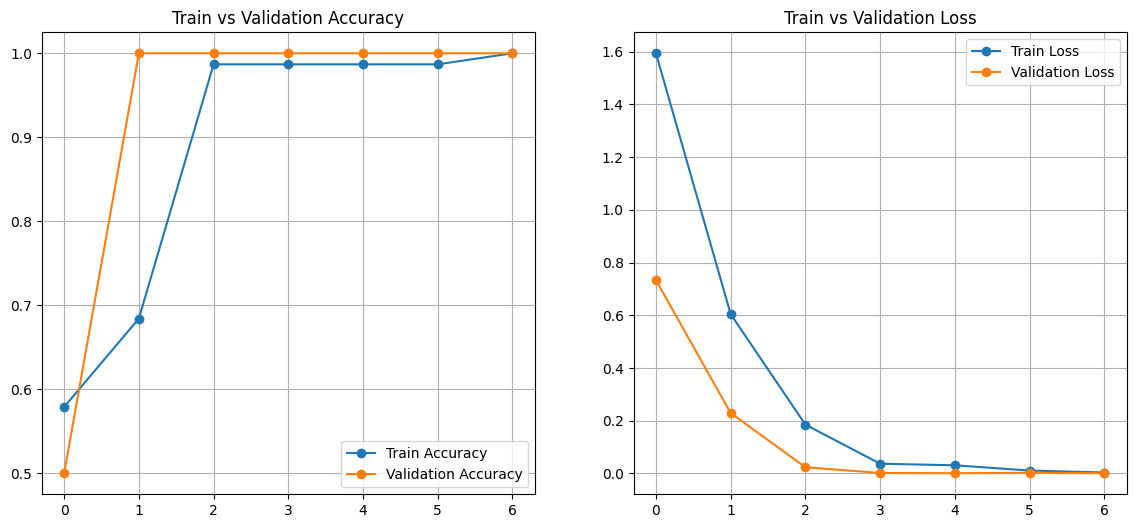

In [26]:
# Accuracy and Loss curves
plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], marker='o', label='Train Accuracy')
plt.plot(history.history['val_accuracy'], marker='o', label='Validation Accuracy')
plt.title('Train vs Validation Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(history.history['loss'], marker='o', label='Train Loss')
plt.plot(history.history['val_loss'], marker='o', label='Validation Loss')
plt.title('Train vs Validation Loss')
plt.legend()
plt.grid(True)

plt.show()

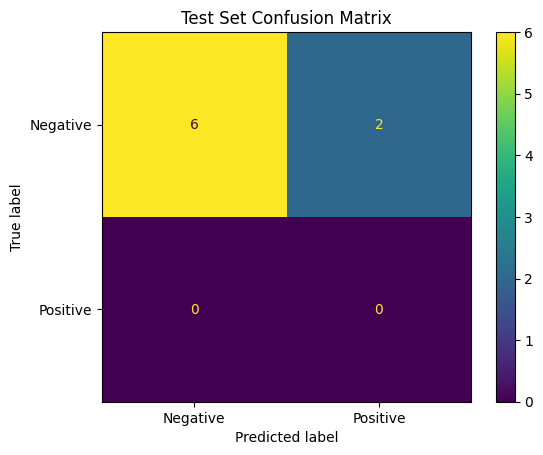

In [27]:
from sklearn.metrics import auc, ConfusionMatrixDisplay, confusion_matrix

y_test = np.array(y_true)
y_prob = np.array(y_pred_proba)
y_pred = (y_prob > 0.5).astype(int)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative','Positive'])
disp.plot()
plt.title("Test Set Confusion Matrix")
plt.show()

In [28]:
window_size = 4242
stride = 500
def predict_hla_in_fasta(fasta_path):
    print(f"Reading FASTA file: {fasta_path}")
    seq = read_fasta(fasta_path)
    print(f"Sequence length: {len(seq)}")

    windows = list(sliding_windows(seq, window_size, stride))
    print(f"Number of windows: {len(windows)}")

    if not windows:
        print("No windows generated. Check sequence length and window size.")
        return

    X_new = np.array([one_hot_encode(w) for w in windows])
    preds = model.predict(X_new)
    max_pred = np.max(preds)
    print(f"Max predicted probability of HLA-B27 presence: {max_pred:.4f}")

    if max_pred > 0.5:
        print("Likely HLA-B27 POSITIVE.")
    else:
        print("Likely HLA-B27 NEGATIVE.")

In [29]:
from sklearn.metrics import accuracy_score

# y_test contains the true labels (1 for positive, 0 for negative)
# y_prob contains the predicted probabilities from model on test files
# y_pred is binary prediction thresholded at 0.5

y_pred = (y_prob > 0.5).astype(int)  # converting probabilities to 0/1 predictions

test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Test Accuracy: 75.00%


In [30]:
model.save("hla_b27_model.h5")